In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import os, shutil
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision
import time
import pdb

#from sklearn.model_selection import train_test_split
from pathlib import Path
from torch import nn
from torch.utils.data.dataset import Dataset
from torchvision import models, transforms
from collections import defaultdict
from random import shuffle
from PIL import Image
from shapely.geometry import Polygon
import torch.backends.cudnn as cudnn
from tqdm import tqdm_notebook

%matplotlib inline

In [20]:
data = pd.read_csv('pklot_non_rotated.csv')

In [21]:
data.head()

,image_path,occupied,rotated_bbox
0,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 ...,577 554 724 717 629 486 780 639 665 416 798 54...
1,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 ...,577 554 724 717 629 486 780 639 665 416 798 54...
2,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 ...,577 554 724 717 629 486 780 639 665 416 798 54...
3,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 ...,577 554 724 717 629 486 780 639 665 416 798 54...
4,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 ...,577 554 724 717 629 486 780 639 665 416 798 54...


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12416 entries, 0 to 12415
Data columns (total 3 columns):
image_path      12416 non-null object
occupied        12416 non-null object
rotated_bbox    12416 non-null object
dtypes: object(3)
memory usage: 291.1+ KB


In [23]:
data['rotated_bbox'] = data['rotated_bbox'].map(lambda x: np.array([int(num) for num in x.split()]))
data['rotated_bbox'] = data['rotated_bbox'].map(lambda x: np.split(x, len(x) / 4))
data['occupied'] = data['occupied'].map(lambda x: [int(num) for num in x.split()])
data['image_path'] = data['image_path'].map(lambda x: Path(x))

In [24]:
data.head()

,image_path,occupied,rotated_bbox
0,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[[577, 554, 724, 717], [629, 486, 780, 639], [..."
1,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[[577, 554, 724, 717], [629, 486, 780, 639], [..."
2,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[[577, 554, 724, 717], [629, 486, 780, 639], [..."
3,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[[577, 554, 724, 717], [629, 486, 780, 639], [..."
4,PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[[577, 554, 724, 717], [629, 486, 780, 639], [..."


## Visualizations

In [35]:
def show_img(image, figsize=None, ax=None):
    """
    Plot an image on an axis. If don't pass an axis it creates a new one with the given figsize.
    :param image: BGR formatted np array from pytorch
    :param figsize(Optional): figure size for the new axis
    :param ax(Optional: axis to plot the image.
    :return: None
    """
    if not ax: 
        fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def bbox_to_contours(xmin, ymin, xmax, ymax):
    """
    Return the four contours for a bounding box
    :return: ((x1, y1), (x2, y2), (x3, y3), (x4, y4))
    """
    
    return ((xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin))


def create_polygon(xmin, ymin, xmax, ymax):
    return Polygon(bbox_to_contours(xmin, ymin, xmax, ymax))

def create_polygon_list(bboxes):
    return [create_polygon(box[0], box[1], box[2], box[3]) for box in bboxes]

def draw_poly(ax, poly, c='black', linewidth=2):
    x,y = poly.exterior.xy
    ax.plot(x, y, color=c, alpha=0.7, linewidth=linewidth, solid_capstyle='round', zorder=2)

def show_truth(image, bboxes, labels, ax, linewidth):
    polygons = create_polygon_list(bboxes)
    labels = [int(num) for num in labels]
    show_img(image, ax=ax)
    
    legend_elements = [Patch(edgecolor='g', label='Occupied', fill=False), 
                       Patch(edgecolor='r', label='Empty', fill=False)]
    ax.legend(handles=legend_elements, loc='upper right')
    
    color_map = {0: 'r', 1: 'g'}

    for i, poly in enumerate(polygons):
        draw_poly(ax, poly, c=color_map[labels[i]], linewidth=linewidth)

In [36]:
data.iloc[0]

image_path      PKLot/PKLot/UFPR04/Rainy/2013-01-18/2013-01-18...
occupied        [0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...
rotated_bbox    [[577, 554, 724, 717], [629, 486, 780, 639], [...
Name: 0, dtype: object

In [37]:
# Loading images
images = []
bboxes = []
labels = []
for i in range(20):
    images.append(plt.imread(data.loc[i, 'image_path']))
    labels.append(data.loc[i, 'occupied'])
    bboxes.append(data.loc[i, 'rotated_bbox'])

In [38]:
images = np.array(images)

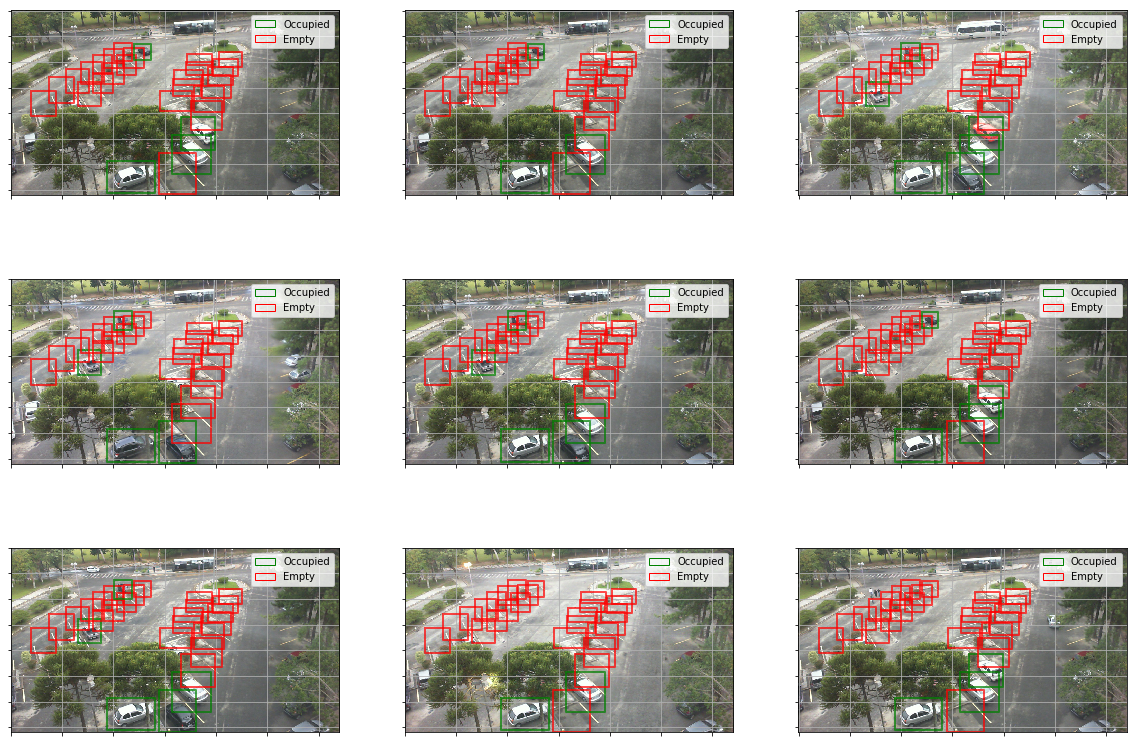

In [39]:
fig, axes = plt.subplots(3, 3, figsize=(20,14))

for i, ax in enumerate(axes.flat):
    #ax.add_patch(patches.Rectangle(xy, rotated_bboxes[0][0][3], rotated_bboxes[0][0][2], rotated_bboxes[0][0][4]))
    #ax = fig.add_subplot(nrows=2, ncols=num_images // 2, index=idx + 1, xticks=[], yticks=[])
    show_truth(images[i], bboxes[i], labels[i], ax, linewidth=2)